# Decision Trees and Random Forests

Nous allons examiner ici un algorithme puissant, un algorithme non paramétrique appelé *forêts aléatoires*.
Les forêts aléatoires sont un exemple de méthode *ensemble*, ce qui signifie qu'elles reposent sur l'agrégation des résultats d'un ensemble d'estimateurs plus simples.
Le résultat quelque peu surprenant de ces méthodes d'ensemble est que la somme peut être supérieure aux parties : c'est-à-dire qu'un vote majoritaire parmi un certain nombre d'estimateurs peut finir par être meilleur que n'importe lequel des estimateurs individuels effectuant le vote !
Nous commençons par les importations standard :

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Decision Trees

Les forêts aléatoires sont un exemple d'un *apprentissage d'ensemble* construit sur des arbres de décision. Pour cette raison, nous allons commencer par parler des arbres de décision eux-mêmes.

Les arbres de décision sont des moyens extrêmement intuitifs de classifier ou d'étiqueter des objets : il suffit de poser une série de questions destinées à déterminer la classification.
Par exemple, si vous souhaitez construire un arbre de décision pour classer un animal que vous rencontrez lors d'une randonnée, vous pourriez construire l'arbre illustré ici :

Le fractionnement binaire rend cette opération extrêmement efficace : dans un arbre bien construit, chaque question réduira le nombre d'options d'environ la moitié, ce qui permet de réduire très rapidement les options, même parmi un grand nombre de classes.
L'astuce, bien sûr, consiste à décider des questions à poser à chaque étape.
Dans les implémentations d'apprentissage automatique des arbres de décision, les questions prennent généralement la forme de divisions alignées sur l'axe dans les données : c'est-à-dire que chaque nœud de l'arbre divise les données en deux groupes en utilisant une valeur de coupure dans l'une des caractéristiques.
Examinons maintenant un exemple de ce type.

### Création d'un arbre de décision

Considérons les données bidimensionnelles suivantes, qui ont une des quatre étiquettes de classe :

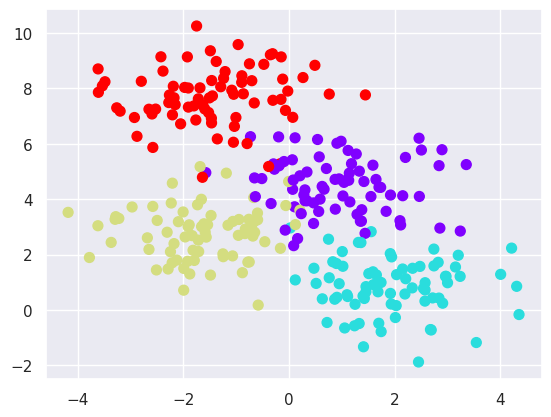

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un arbre de décision simple construit sur ces données divisera itérativement les données le long de l'un ou l'autre axe selon un critère quantitatif, et à chaque niveau, attribuera l'étiquette de la nouvelle région selon un vote majoritaire des points qui la composent.
Cette figure présente une visualisation des quatre premiers niveaux d'un classificateur à arbre de décision pour ces données :

Remarquez qu'après la première division, chaque point de la branche supérieure reste inchangé, il n'est donc pas nécessaire de subdiviser davantage cette branche.
A l'exception des noeuds qui contiennent tous une couleur, à chaque niveau *toutes* les régions sont à nouveau divisées selon l'une des deux caractéristiques.

Ce processus d'adaptation d'un arbre de décision à nos données peut être réalisé dans Scikit-Learn avec l'estimateur ``DecisionTreeClassifier`` :

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))

    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

<ipython-input-4-7157cf2cd6c2>:22: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


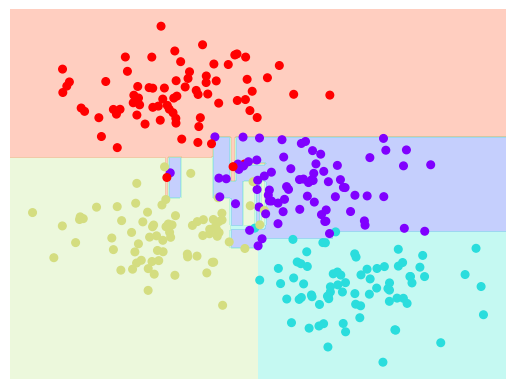

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Remarquez qu'à mesure que la profondeur augmente, nous avons tendance à obtenir des régions de classification de forme très étrange ; par exemple, à une profondeur de cinq, il y a une région violette haute et maigre entre les régions jaune et bleue.
Il est clair que cela résulte moins de la distribution intrinsèque des données que de l'échantillonnage particulier ou des propriétés du bruit des données.
En d'autres termes, cet arbre de décision, même s'il n'a que cinq niveaux de profondeur, est clairement surajusté à nos données.

## Ensembles d'estimateurs : Forêts aléatoires

Cette notion, à savoir que plusieurs estimateurs surajustés peuvent être combinés pour réduire l'effet de cette surajustement, est à la base d'une méthode d'ensemble appelée *bagging*.
La mise en sac utilise un ensemble (un sac à main, peut-être) d'estimateurs parallèles, chacun d'entre eux surajustant les données, et fait la moyenne des résultats pour trouver une meilleure classification.
Un ensemble d'arbres de décision aléatoires est connu sous le nom de *forêt aléatoire*.

Ce type de classification en sac peut être réalisé manuellement en utilisant le méta-estimateur ``BaggingClassifier`` de Scikit-Learn, comme illustré ici :

<ipython-input-4-7157cf2cd6c2>:22: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


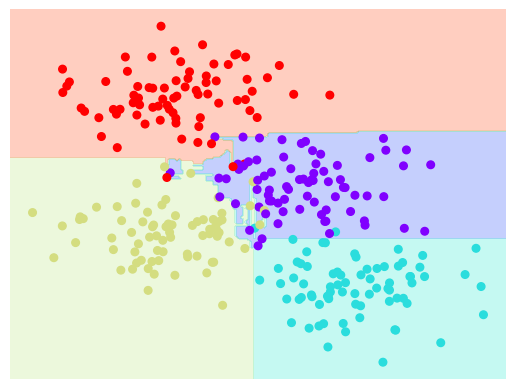

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

Dans cet exemple, nous avons randomisé les données en ajustant chaque estimateur avec un sous-ensemble aléatoire de 80% des points d'apprentissage.
En pratique, les arbres de décision sont plus efficacement randomisés en injectant une certaine stochasticité dans la façon dont les divisions sont choisies : de cette façon, toutes les données contribuent à l'ajustement à chaque fois, mais les résultats de l'ajustement ont toujours le caractère aléatoire souhaité.

Par exemple, pour déterminer la caractéristique sur laquelle il faut se diviser, l'arbre aléatoire peut choisir parmi les caractéristiques les plus importantes.


Dans Scikit-Learn, un tel ensemble optimisé d'arbres de décision aléatoires est implémenté dans l'estimateur ``RandomForestClassifier``, qui se charge automatiquement de toute la randomisation.

Tout ce que vous avez à faire est de sélectionner un certain nombre d'estimateurs, et il ajustera très rapidement (en parallèle, si vous le souhaitez) l'ensemble d'arbres :

<ipython-input-4-7157cf2cd6c2>:22: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


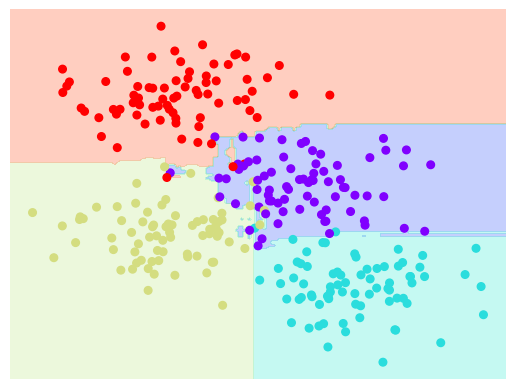

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Nous constatons qu'en faisant la moyenne de 100 modèles perturbés de façon aléatoire, nous obtenons un modèle global qui est beaucoup plus proche de notre intuition sur la façon dont l'espace des paramètres devrait être divisé.

## Random Forest Regression

Dans la section précédente, nous avons considéré les forêts aléatoires dans le contexte de la classification.
Les forêts aléatoires peuvent également être utilisées dans le cas de la régression (c'est-à-dire pour des variables continues plutôt que catégoriques). L'estimateur à utiliser pour cela est le ``RandomForestRegressor``, et la syntaxe est très similaire à ce que nous avons vu précédemment.

Considérons les données suivantes, tirées de la combinaison d'une oscillation rapide et lente :

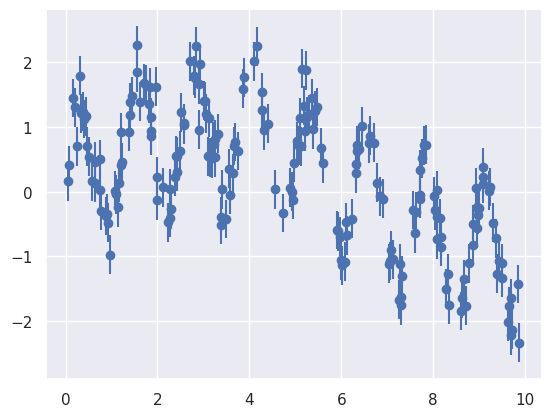

In [8]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

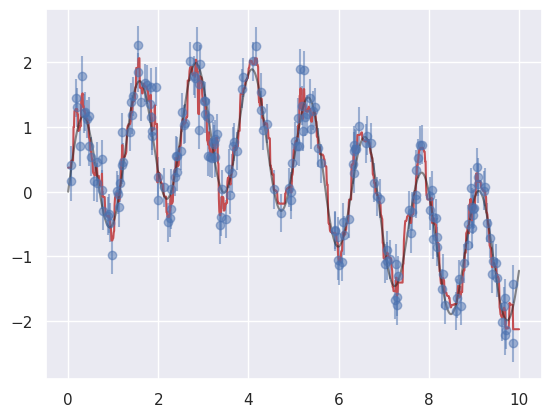

In [9]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Ici, le vrai modèle est représenté par la courbe grise lisse, tandis que le modèle de forêt aléatoire est représenté par la courbe rouge dentelée.
Comme vous pouvez le constater, le modèle non paramétrique de forêt aléatoire est suffisamment flexible pour s'adapter aux données multi-périodes, sans que nous ayons besoin de spécifier un modèle multi-périodes !

## Exemple

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

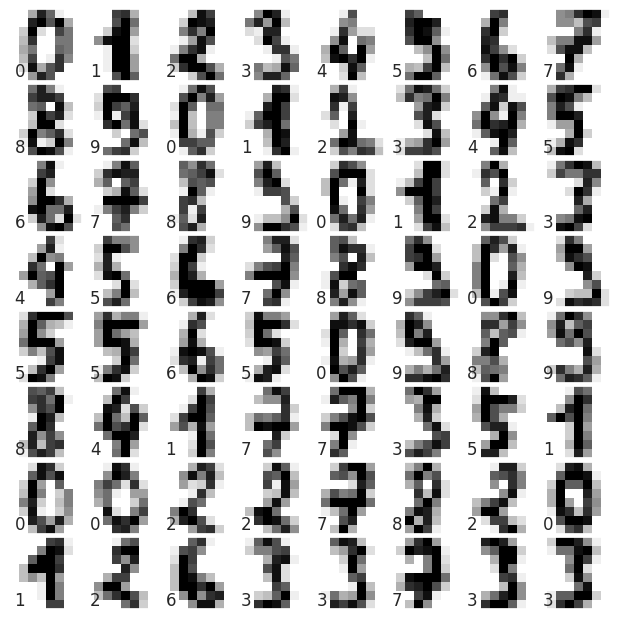

In [11]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [12]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [13]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



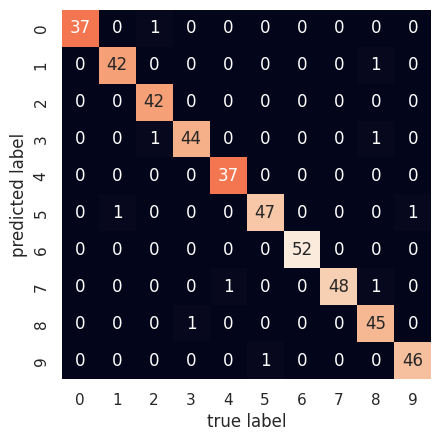

In [14]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Résumé des forêts aléatoires

Les forêts aléatoires sont une méthode puissante qui présente plusieurs avantages :

- La formation et la prédiction sont toutes deux très rapides, en raison de la simplicité des arbres de décision sous-jacents. En outre, les deux tâches peuvent être directement parallélisées, car les arbres individuels sont des entités entièrement indépendantes.
- Les arbres multiples permettent une classification probabiliste : un vote majoritaire parmi les estimateurs donne une estimation de la probabilité (accessible dans Scikit-Learn avec la méthode ``predict_proba()``).
- Le modèle non paramétrique est extrêmement flexible, et peut donc être performant sur des tâches qui sont sous-estimées par d'autres estimateurs.

L'un des principaux inconvénients des forêts aléatoires est que les résultats ne sont pas facilement interprétables : en d'autres termes, si vous souhaitez tirer des conclusions sur le *sens* du modèle de classification, les forêts aléatoires ne sont peut-être pas le meilleur choix.